In [0]:
import json
import pandas as pd
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
import os



with open('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/dataset.json') as d:
  json = json.load(d)

path = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen'


# def ui():

i = 0

for u in json['training']:
  input_ = u['image']
  label_ = u['label']
  input_path = "".join(list(input_)[1:])
  label_path = "".join(list(label_)[1:])
  images = nib.load(path+input_path)
  labels = nib.load(path+label_path)

  if not os.path.exists(path+'/input'):
    os.mkdir(path+'/input')
  if not os.path.exists(path+'/target'):
    os.mkdir(path+'/target')
    
  image_ = images.get_data()
  target_ = labels.get_data()
  
  p = np.asarray(image_)
  p = (p*255).astype('uint8')

  q = np.asarray(target_)
  q = (q*255).astype('uint8')

  for third in range(images.shape[2]):

    po = Image.fromarray(p[:,:,third])
    po1 = po.resize((200,200))
    po1.save(path+'/input'+f'/input_{i}.jpg')       
    
    qo = Image.fromarray(q[:,:,third])
    qo1 = qo.resize((200,200))
    qo1.save(path+'/target'+f'/target_{i}.jpg')
    
    i += 1


  #     plt.imshow(image_)
  #     plt.axis('off')
  #     # plt.figure(figsize=(3.5,3.5))
  #     plt.savefig(path+'/input'+f'/input_{i}.jpg')

      # if i==29:
      #   return print("fgj")     


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [0]:
for o,u in enumerate(os.scandir('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/target')):
  pass
o


3649

In [0]:
from fastai import *
from fastai.vision import *       

In [0]:
bs=16      

In [0]:
path = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/target/'
# path1 = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/input/'

label_func = lambda x : path + 'target_'+(x.name).split("_")[1]  #input_{i}.jpg
# same_func = lambda x: path1+x.name

IL = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/input/')
LL = IL.split_by_rand_pct(valid_pct=0.2).label_from_func(label_func)
data = LL.transform(get_transforms(max_zoom=1.1, max_lighting=None, max_warp=None),tfm_y=True).databunch(bs=bs).normalize(imagenet_stats,do_y=True)


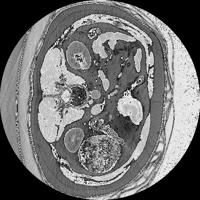

In [5]:
data.train_dl.x[15]   

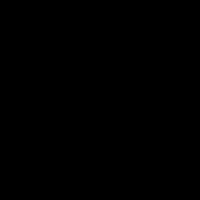

In [6]:
data.train_dl.y[15]  

In [7]:
import fastai                                   
import torch                                  
from fastai import *                          
from fastai.vision import *                 
from fastai.callbacks import *               
from fastai.utils.mem import *               
from torchvision.models import vgg16_bn 

arch = models.resnet34


# valid_ds gives you data with input and target 
# and dl gives you generator which you can iterate

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)          


# gram_matrix(t)


base_loss = F.l1_loss


vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)


blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
# blocks, [vgg_m[i] for i in blocks]


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()


feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
L1_loss = torch.nn.L1Loss()

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=L1_loss,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


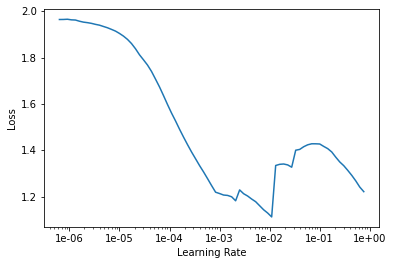

In [12]:
learn.lr_find()
learn.recorder.plot() 

In [0]:
lr = 9e-05

In [0]:
def do_fit(save_name, lrs, pct_start=0.7):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,time
0,0.208804,0.174902,16:25
1,0.108400,0.107999,03:04
2,0.114662,0.112842,03:04
3,0.124612,0.119810,03:04
4,0.106651,0.074537,03:03
5,0.104789,0.068263,03:02
6,0.090879,0.061231,03:02
7,0.062252,0.061528,03:02
8,0.041681,0.033816,03:02
9,0.028668,0.028927,03:02


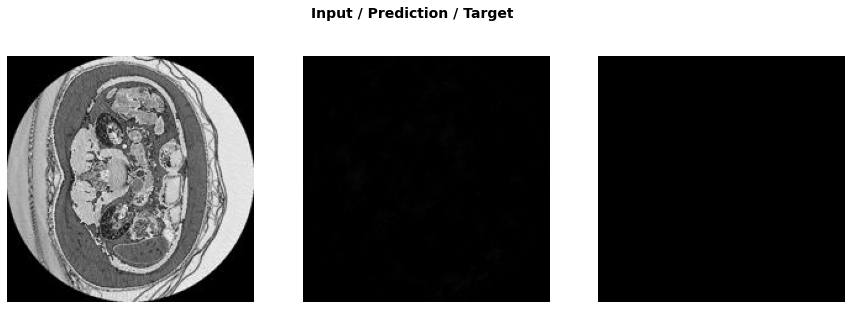

In [15]:
do_fit('1a', slice(lr*10))          

In [0]:
learn.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/model_weights')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.027442,0.030431,03:14
1,0.026857,0.026871,03:14
2,0.026825,0.030065,03:14
3,0.035313,0.044758,03:14
4,0.039419,0.025587,03:13
5,0.042786,0.024755,03:13
6,0.046582,0.020045,03:13
7,0.043807,0.020415,03:13
8,0.021203,0.019699,03:13
9,0.012061,0.012335,03:13


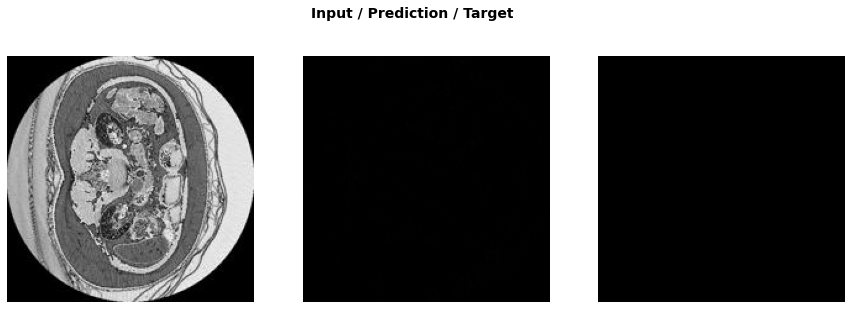

In [18]:
do_fit('1a', slice(lr,lr*10)) 

In [0]:
learn.export('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/model.hdf5')

In [0]:
learn.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/')

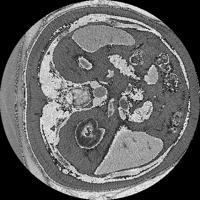

In [21]:
image = open_image('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/input/input_23.jpg')
image

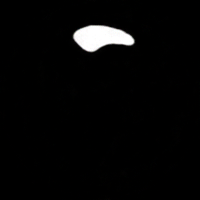

In [23]:
q,w,e = learn.predict(image)
q